# Introduction
This notebook performs a Sobol global sensitivity analysis to identify the most influential parameters on the expected annual damage and the expected number of deaths.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench.em_framework import get_SALib_problem
from SALib.analyze import sobol

In [16]:
# Define problem formulation
from problem_formulation import get_model_for_problem_formulation
dike_model, planning_steps = get_model_for_problem_formulation(3)

INFO:dike_model_function:Model initialized


In [17]:
# Outcomes from the CSV files 
outcomes_zp = pd.read_csv('data/Output/open_exploration_outcomes_zero.csv')
outcomes_rp = pd.read_csv('data/Output/open_exploration_outcomes_random.csv')

# Experiments form the CSV files 
experiments_zp = pd.read_csv('data/Output/open_exploration_experiments_zero.csv')
experiments_rp = pd.read_csv('data/Output/open_exploration_experiments_random.csv')

# Columns to keep for the analysis
columns_to_keep = [
    'A.4_Expected Annual Damage',
    'A.4_Dike Investment Costs',
    'RfR Total Costs',
    'Expected Evacuation Costs',
    'A.4_Expected Number of Deaths',    
    'policy'
]

# Filter specific for outcomes_zp
outcomes_zp = outcomes_zp[columns_to_keep]

# Filter specific for outcomes_rp
outcomes_rp = outcomes_rp[columns_to_keep]

# A list has been created of uncertainties in the model
uncertainties_list = ['discount rate 0','discount rate 1',
                         'discount rate 2', 'A.0_ID flood wave shape',
                         'A.1_Bmax','A.1_pfail','A.1_Brate',
                         'A.2_Bmax','A.2_pfail','A.2_Brate',
                         'A.3_Bmax','A.3_pfail','A.3_Brate',
                         'A.4_Bmax','A.4_pfail','A.4_Brate',
                         'A.5_Bmax','A.5_pfail','A.5_Brate',]

uncertainties_ezp = experiments_zp.loc[:,uncertainties_list]
uncertainties_erp = experiments_rp.loc[:,uncertainties_list]

# 3. Global Sensitivity Analysis

This section presents the outcomes of the Global Sensitivity Analysis using the Sobol method. The Sobol analysis results, generated in the `open_exploration_SOBOL.py` file, are retrieved prior to execution. This analysis includes 1024 scenarios.

Due to time constraints and computational limitations, the Sobol analysis was only performed for the zero policy scenario. This scenario was deemed the most insightful because understanding the impact of uncertainties on model outcomes without any interventions is crucial for the reference scenario to be developed in subsequent steps of the MORDM analysis. Focusing on the zero policy means that the Sobol analysis only examines the Expected Number of Deaths and the Expected Annual Damage.



In [18]:
SOBOL_problem = get_SALib_problem(dike_model.uncertainties)
SOBOL_problem

{'num_vars': 19,
 'names': ['A.0_ID flood wave shape',
  'A.1_Bmax',
  'A.1_Brate',
  'A.1_pfail',
  'A.2_Bmax',
  'A.2_Brate',
  'A.2_pfail',
  'A.3_Bmax',
  'A.3_Brate',
  'A.3_pfail',
  'A.4_Bmax',
  'A.4_Brate',
  'A.4_pfail',
  'A.5_Bmax',
  'A.5_Brate',
  'A.5_pfail',
  'discount rate 0',
  'discount rate 1',
  'discount rate 2'],
 'bounds': [(0, 133),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (0, 4),
  (0, 4),
  (0, 4)]}

In [19]:
# Retrieve data from Sobol run
sobol_experiments = pd.read_csv('data/output/sobol_experiments_results.csv')
sobol_outcomes = pd.read_csv('data/output/sobol_outcomes_results.csv')

## 3.1 Sobol for Expected Annual Damage

The study focuses on conducting Sobol sensitivity analysis on uncertainties related to annual damage and expected deaths. This analysis specifically examines the indices S1 and ST, with error bars representing confidence intervals.  
The S1 index quantifies the individual contribution of each input variable, while the ST index offers a comprehensive view by accounting for both direct and indirect effects, including interactions between inputs.


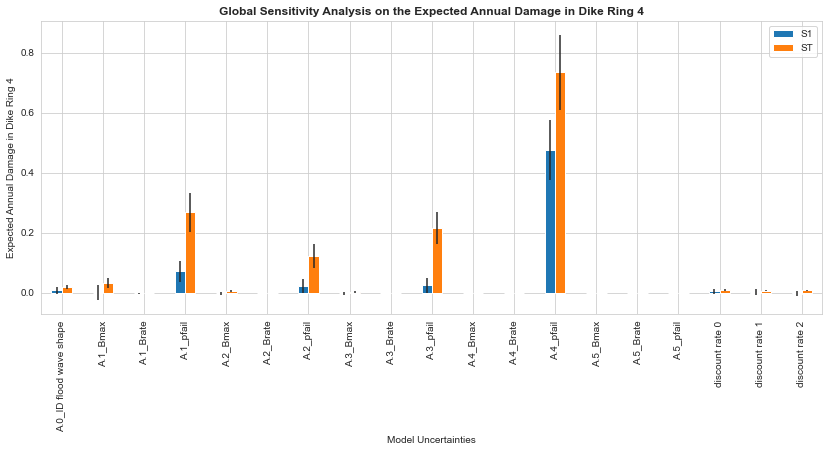

In [20]:
sobol_costs_results = {}

for policy in sobol_experiments['policy'].unique():
    logical = sobol_experiments['policy'] == policy
    y = sobol_outcomes.loc[logical, 'A.4_Expected Annual Damage'].values
    indices = sobol.analyze(SOBOL_problem, y)
    sobol_costs_results[policy] = indices

# Example for a specific policy
policy = sobol_experiments['policy'].unique()[0]
sobol_indices = sobol_costs_results[policy]
scores_filtered = {k: sobol_indices[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
sobol_indices_df = pd.DataFrame(scores_filtered, index=SOBOL_problem["names"])

# Plotting the results
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

indices = sobol_indices_df[["S1", "ST"]]
confidence = sobol_indices_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=confidence.values.T, ax=ax)
fig.subplots_adjust(bottom=0.3)

# Graph setup
plt.title('Global Sensitivity Analysis on the Expected Annual Damage in Dike Ring 4', fontweight='bold')
plt.xlabel('Model Uncertainties')
plt.ylabel('Expected Annual Damage in Dike Ring 4')
plt.show()

The Sobol sensitivity analysis graph displays the annual damage in Dike Ring 4 as a function of various model uncertainties. The analysis uses two sensitivity indices, S1 and ST, to understand the impact of each input variable on the output.

#### Indices S1 and ST:
- **S1 Index (Blue)**: This represents the first-order sensitivity index, which measures the individual effect of each input variable on the expected number of deaths, ignoring interactions with other variables.
- **ST Index (Orange)**: This represents the total sensitivity index, accounting for both the direct effect of the input variable and its interactions with other variables.

#### Error Bars:
- The error bars indicate the confidence intervals for both S1 and ST indices, providing an estimate of the uncertainty in these sensitivity measures.

#### Significant Variables:
- **A1_pfail** and **A4_pfail**: These variables have the highest ST indices, indicating that they have the most significant total effect on the expected number of deaths, including both their individual effects and interactions with other variables.

## 3.2 Sobol for the Expected Number of Deaths

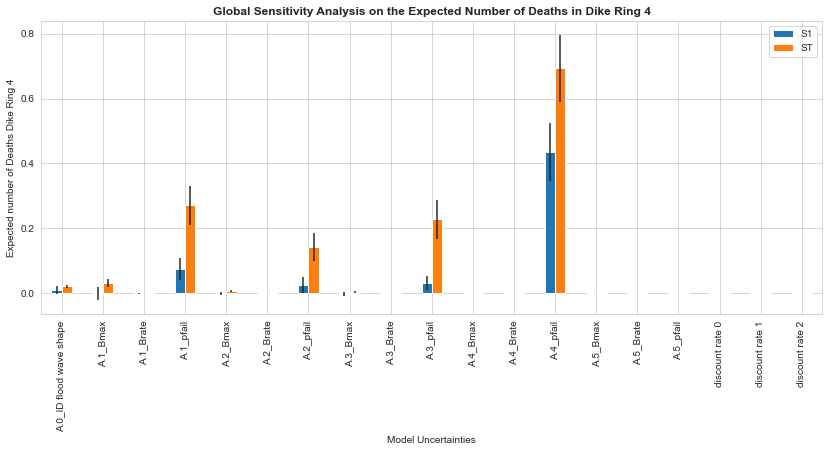

In [21]:

# Calculate Sobol indices for the specific outcome
sobol_deaths_results = {}
for policy in sobol_experiments.policy.unique():
    logical = sobol_experiments.policy == policy
    y = sobol_outcomes.loc[logical, 'A.4_Expected Number of Deaths'].values
    indices = sobol.analyze(SOBOL_problem, y)
    sobol_deaths_results[policy] = indices

# Example for a specific policy
policy = sobol_experiments.policy.unique()[0]
sobol_indices = sobol_deaths_results[policy]
scores_filtered = {k: sobol_indices[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
sobol_indices_df = pd.DataFrame(scores_filtered, index=SOBOL_problem["names"])

# Plotting the results
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

indices = sobol_indices_df[["S1", "ST"]]
confidence = sobol_indices_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=confidence.values.T, ax=ax)
fig.subplots_adjust(bottom=0.3)

# Graph setup
plt.title('Global Sensitivity Analysis on the Expected Number of Deaths in Dike Ring 4', fontweight='bold')
plt.xlabel('Model Uncertainties')
plt.ylabel('Expected number of Deaths Dike Ring 4')
plt.show()


The Sobol sensitivity analysis graph displays the expected number of deaths in Dike Ring 4 as a function of various model uncertainties. The analysis uses two sensitivity indices, S1 and ST, to understand the impact of each input variable on the output.

#### Indices S1 and ST:
- **S1 Index (Blue)**: This represents the first-order sensitivity index, which measures the individual effect of each input variable on the expected number of deaths, ignoring interactions with other variables.
- **ST Index (Orange)**: This represents the total sensitivity index, accounting for both the direct effect of the input variable and its interactions with other variables.

#### Error Bars:
- The error bars indicate the confidence intervals for both S1 and ST indices, providing an estimate of the uncertainty in these sensitivity measures.

#### Significant Variables:
- **A1_pfail** and **A4_pfail**: These variables have the highest ST indices, indicating that they have the most significant total effect on the expected number of deaths, including both their individual effects and interactions with other variables.

### Conclusion:
The Sobol sensitivity analysis highlights that the probability of failure (pfail) variables, especially **A1_pfail** and **A4_pfail**, are the most influential factors affecting the expected number of deaths in Dike Ring 4. These variables not only have strong individual impacts but also interact significantly with other variables. Other uncertainties, such as the discount rates and flood wave shape, have minimal impact on the expected outcomes.